In [7]:
# --- Step 1: Imports and Setup ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Import the snnTorch library
import snntorch as snn
from snntorch import spikegen

print("--- Step 1: Libraries imported successfully ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("-" * 50 + "\n")



--- Step 1: Libraries imported successfully ---
Using device: cpu
--------------------------------------------------



In [8]:

# --- Step 2: Load and Prepare the PTBDB Data ---
print("--- Step 2: Loading and Preparing PTBDB Data ---")
try:
    df = pd.concat([pd.read_csv("ptbdb_normal.csv", header=None).assign(label=0),
                    pd.read_csv("ptbdb_abnormal.csv", header=None).assign(label=1)])
    df = shuffle(df, random_state=42)
    print("PTBDB dataset loaded successfully.")
except FileNotFoundError:
    print("ERROR: Make sure both data files are in the same folder.")
    exit()

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values.astype(np.int64)

# Create Train, Validation, and Test splits (80-10-10)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val) # 0.125 * 0.8 = 0.1

# Convert to PyTorch Tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

print(f"Data split into Train ({len(X_train)}), Validation ({len(X_val)}), and Test ({len(X_test)}) sets.")
print("-" * 50 + "\n")



--- Step 2: Loading and Preparing PTBDB Data ---
PTBDB dataset loaded successfully.
Data split into Train (10185), Validation (1456), and Test (2911) sets.
--------------------------------------------------



In [9]:

# --- Step 3: Define the RANSNN Architecture as a Class ---
print("--- Step 3: Defining the RANSNN Architecture ---")
class RANSNN(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, beta):
        super().__init__()
        self.spiking_part = nn.Sequential(
            nn.Linear(num_inputs, num_hidden),
            snn.Leaky(beta=beta, init_hidden=True)
        )
        for param in self.spiking_part.parameters():
            param.requires_grad = False
        self.readout = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        num_steps = x.shape[0]
        hidden_spikes_list = []
        for step in range(num_steps):
            spk_hidden = self.spiking_part(x[step])
            hidden_spikes_list.append(spk_hidden)
        stacked_hidden_spikes = torch.stack(hidden_spikes_list, dim=0)
        spike_counts = torch.sum(stacked_hidden_spikes, dim=0)
        final_outputs = self.readout(spike_counts)
        return final_outputs, stacked_hidden_spikes

num_inputs  = X_train.shape[1]
num_hidden  = 256
num_outputs = 2
beta        = 0.95
net = RANSNN(num_inputs, num_hidden, num_outputs, beta).to(device)
print("RANSNN Architecture defined successfully.")
print("-" * 50 + "\n")




--- Step 3: Defining the RANSNN Architecture ---
RANSNN Architecture defined successfully.
--------------------------------------------------



In [10]:
# --- Step 4: Training Loop with Validation ---
print("--- Step 4: Starting RANSNN Training with Validation ---")
num_steps = 25
batch_size = 128
epochs = 15 # Increased epochs for better learning visualization
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.readout.parameters(), lr=1e-3)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

# Lists for plotting
train_loss_hist = []
val_loss_hist = []
val_acc_hist = []

start_time = time.time()
for epoch in range(epochs):
    net.train()
    epoch_loss = 0
    for i, (data, targets) in enumerate(train_loader):
        spiked_data = spikegen.rate(data, num_steps=num_steps)
        outputs, _ = net(spiked_data)
        loss = loss_fn(outputs, targets)
        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss_hist.append(epoch_loss / len(train_loader))

    # Validation loop
    net.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for data, targets in val_loader:
            spiked_data = spikegen.rate(data, num_steps=num_steps)
            outputs, _ = net(spiked_data)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == targets).sum().item()
    
    val_loss_hist.append(val_loss / len(val_loader))
    val_acc_hist.append(100 * val_correct / len(y_val))
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss_hist[-1]:.4f}, Val Loss: {val_loss_hist[-1]:.4f}, Val Acc: {val_acc_hist[-1]:.2f}%")

end_time = time.time()
training_time = end_time - start_time
print(f"\nTraining complete in {training_time:.2f} seconds.")
print("-" * 50 + "\n")




--- Step 4: Starting RANSNN Training with Validation ---
Epoch 1/15, Train Loss: 0.3394, Val Loss: 0.1448, Val Acc: 98.49%
Epoch 2/15, Train Loss: 0.1009, Val Loss: 0.0668, Val Acc: 99.79%
Epoch 3/15, Train Loss: 0.0541, Val Loss: 0.0388, Val Acc: 99.93%
Epoch 4/15, Train Loss: 0.0351, Val Loss: 0.0297, Val Acc: 100.00%
Epoch 5/15, Train Loss: 0.0274, Val Loss: 0.0222, Val Acc: 99.93%
Epoch 6/15, Train Loss: 0.0216, Val Loss: 0.0198, Val Acc: 99.93%
Epoch 7/15, Train Loss: 0.0170, Val Loss: 0.0142, Val Acc: 100.00%
Epoch 8/15, Train Loss: 0.0145, Val Loss: 0.0120, Val Acc: 100.00%
Epoch 9/15, Train Loss: 0.0124, Val Loss: 0.0105, Val Acc: 100.00%
Epoch 10/15, Train Loss: 0.0108, Val Loss: 0.0097, Val Acc: 100.00%
Epoch 11/15, Train Loss: 0.0094, Val Loss: 0.0088, Val Acc: 100.00%
Epoch 12/15, Train Loss: 0.0085, Val Loss: 0.0065, Val Acc: 100.00%
Epoch 13/15, Train Loss: 0.0081, Val Loss: 0.0077, Val Acc: 99.86%
Epoch 14/15, Train Loss: 0.0078, Val Loss: 0.0064, Val Acc: 99.93%
Epoch 1

--- Step 5: Plotting Training and Validation History ---


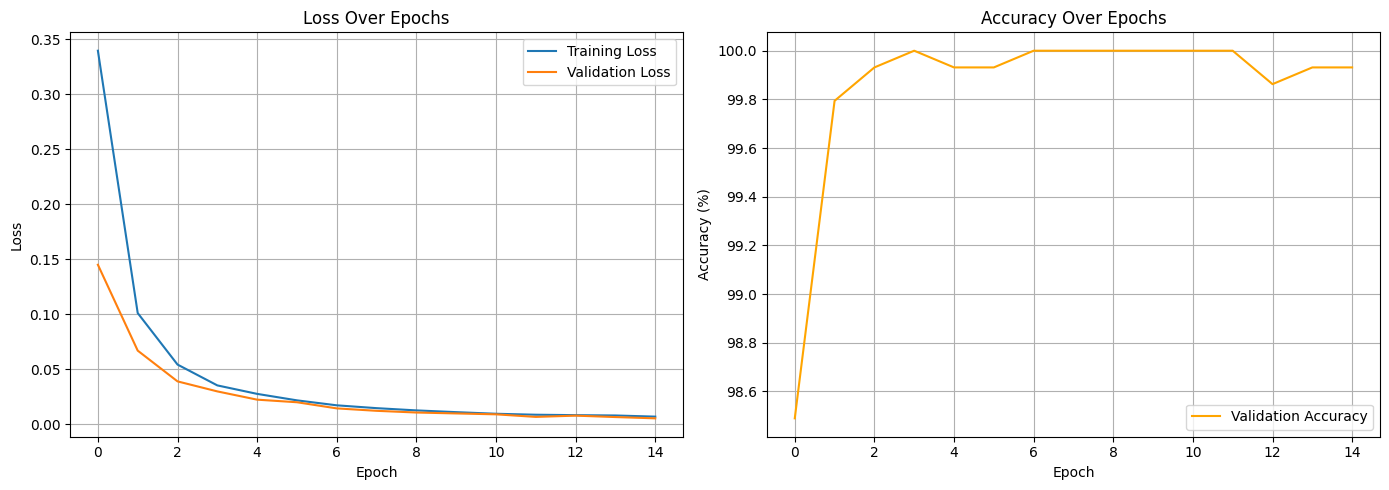

--------------------------------------------------



In [11]:

# --- Step 5: Plotting Training History ---
print("--- Step 5: Plotting Training and Validation History ---")
plt.figure(figsize=(14, 5))
# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label='Training Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_acc_hist, label='Validation Accuracy', color='orange')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
print("-" * 50 + "\n")



--- Step 6: Comprehensive Evaluation on Test Set ---
Final Test Accuracy: 99.97%
Network Sparsity: 95.62%

Classification Report:
                    precision    recall  f1-score   support

  Normal (Class 0)       1.00      1.00      1.00       809
Abnormal (Class 1)       1.00      1.00      1.00      2102

          accuracy                           1.00      2911
         macro avg       1.00      1.00      1.00      2911
      weighted avg       1.00      1.00      1.00      2911

Confusion Matrix:


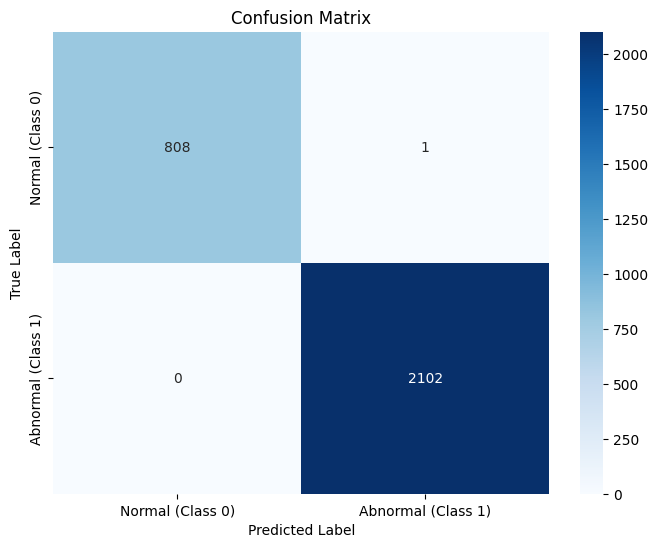

In [12]:

# --- Step 6: Comprehensive Final Evaluation on Test Set ---
print("--- Step 6: Comprehensive Evaluation on Test Set ---")
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
all_targets = []
all_predictions = []
total_spikes = 0
total_neurons = 0

with torch.no_grad():
    net.eval()
    for data, targets in test_loader:
        spiked_data = spikegen.rate(data, num_steps=num_steps)
        outputs, hidden_spikes = net(spiked_data)
        _, predicted = torch.max(outputs.data, 1)
        
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
        total_spikes += torch.sum(hidden_spikes).item()
        total_neurons += hidden_spikes.numel()

accuracy = 100 * np.sum(np.array(all_predictions) == np.array(all_targets)) / len(all_targets)
sparsity = 100 * (1 - total_spikes / total_neurons)

print(f"Final Test Accuracy: {accuracy:.2f}%")
print(f"Network Sparsity: {sparsity:.2f}%\n")

# Classification Report
print("Classification Report:")
class_names = ['Normal (Class 0)', 'Abnormal (Class 1)']
print(classification_report(all_targets, all_predictions, target_names=class_names))

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()